## 시퀀스 배열로 다루는 순환 신경망(RNN)
#### 등장 배경
- 문장을 학습하는 것은 지금까지 공부한 내용과는 성질이 조금 다름
- 문장은 여러 개의 단어로 이루어져 있는데, 그 의미를 전달하려면 각 단어가 정해진 순서대로 입력되어야 하기 때문
- 여러 데이터가 순서와 관계없이 입력되던 것과는 다르게, 이번에는 과거에 입력된 데이터와 나중에 입력된 데이터 사이의 관계를 고려해야 하는 문제가 생김
- 이를 해결하기 위해 *순환 신경망*

#### 순환 신경망(RNN)
- 여러 개의 데이터가 순서대로 입력되었을 때 앞서 입력받은 데이터를 잠시 기억해 놓는 방법
- 기억된 데이터가 얼마나 중요한지 판단하고 별도의 가중치를 주어 다음 데이터로 넘어감
- 모든 입력 값이 작업을 순서대로 실행하므로 다음층으로 넘어가기 전에 같은 층을 맴도는 것 처럼 보임
- 이러한 성질때문에 순환신경망 이라 부름
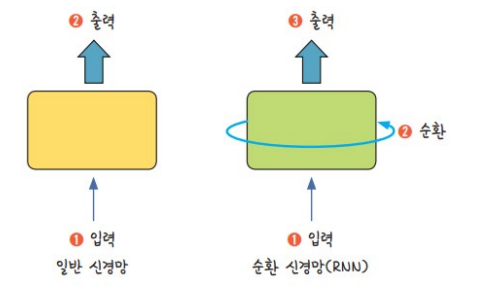

ex) '오늘 주가가 몇이야?' <br>
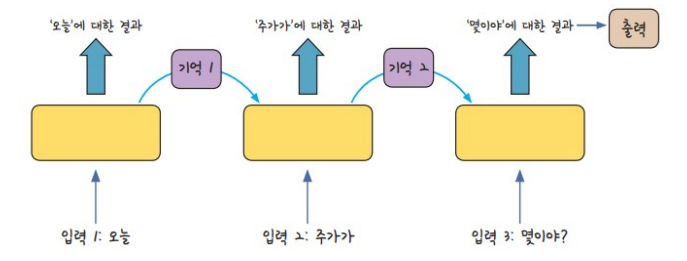

- 순환되는 중에 앞서 나온 입력에 대한 결과가 뒤에 나오는 입력 값에 영향을 주는 것을 알 수 있음
- 비슷한 두 문장이 입력되었을 때 그 차이를 구별해 출력 값에 반영 가능
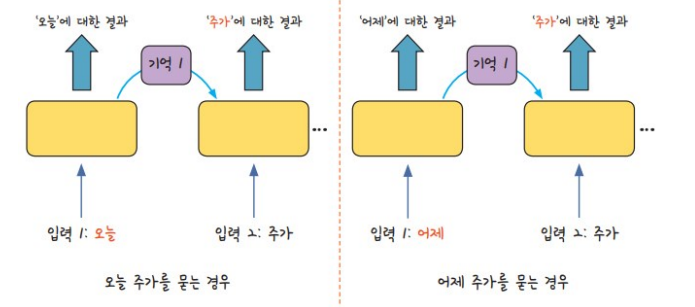

**LSTM(Long Short Term Memory) 방법**
- 한 층 안에서 반복은 많이 해야 하는 RNN의 특성상 일반 신경망보다 기울기 소실 문제가 더 많이 발생하고 이를 해결하기 어렵다는 단점을 보완한 방법
- 반복되기 직전에 다음 층으로 기억된 값을 넘길지 여부를 관리하는 단계를 하나 더 추가하는 것
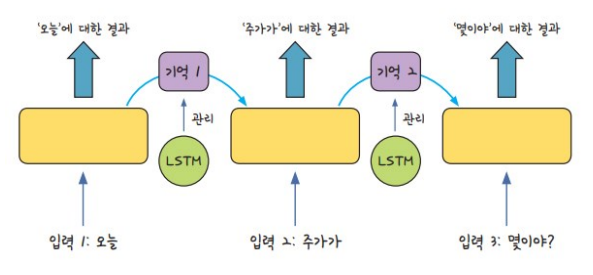

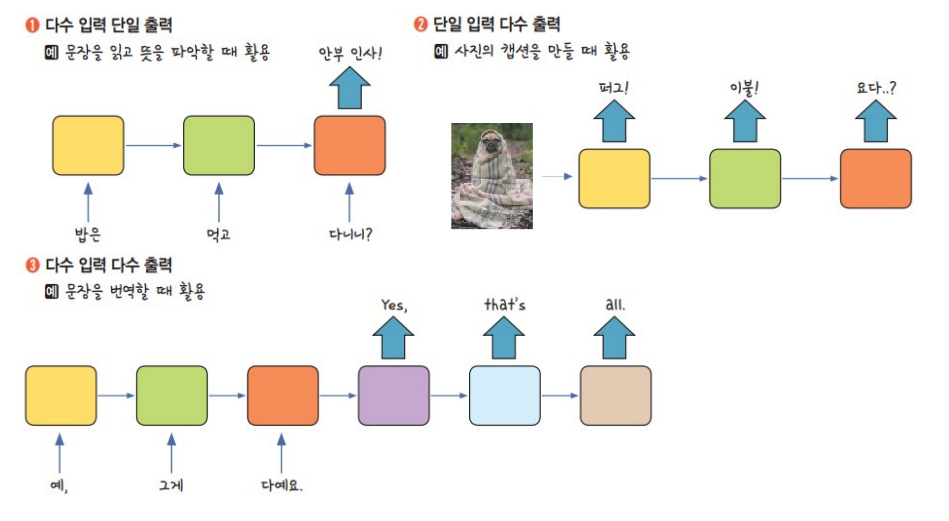
- 이처럼 입력값과 출력값을 어떻게 설정하느냐에 따라 여러 가지 상황에서 적용가능

# 로이터 뉴스 카테고리 분류하기
긴 텍스트를 읽고 이 데이터가 어떤 의미를 지니는지 카테고리로 분류하는 연습<br>
총 1만 1228개의 뉴스 기사가 46개의 카테고리로 나누어진 대용량 텍스트 데이터

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.datasets import reuters       # 로이터 뉴스 데이터셋 불러오기
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt

# 데이터를 불러와 학습셋, 테스트셋으로 나눕니다.
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=1000, test_split=0.2)

# 데이터를 확인해 보겠습니다.
category = np.max(y_train) + 1
print(category, '카테고리')
print(len(X_train), '학습용 뉴스 기사')
print(len(X_test), '테스트용 뉴스 기사')
print(X_train[0])

46 카테고리
8982 학습용 뉴스 기사
2246 테스트용 뉴스 기사
[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 2, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 2, 2, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 2, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


뉴스 기사의 최대 길이 :2376
뉴스 기사의 평균 길이 :145.5398574927633


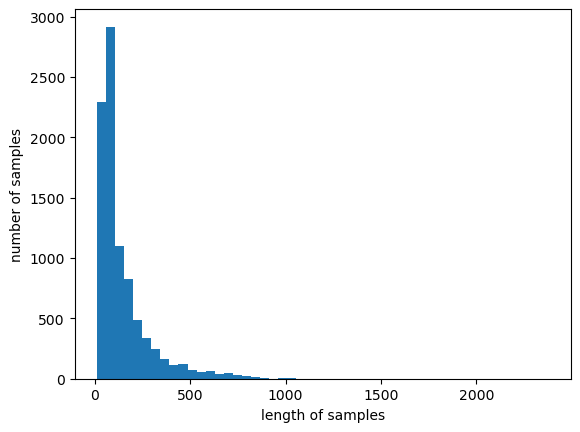

In [2]:
print('뉴스 기사의 최대 길이 :{}'.format(max(len(l) for l in X_train)))
print('뉴스 기사의 평균 길이 :{}'.format(sum(map(len, X_train))/len(X_train)))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

#### 2) 각 뉴스의 레이블 값의 분포를 확인하고 각 레이블에 대한 정확한 개수를 출력

In [3]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 레이블에 대한 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 레이블에 대한 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


####  3) 정수 인코딩된 각 숫자들이 어떤 단어들을 나타내고 있는지 확인

In [4]:
word_to_index = reuters.get_word_index()
print(word_to_index)

{'mdbl': 10996, 'fawc': 16260, 'degussa': 12089, 'woods': 8803, 'hanging': 13796, 'localized': 20672, 'sation': 20673, 'chanthaburi': 20675, 'refunding': 10997, 'hermann': 8804, 'passsengers': 20676, 'stipulate': 20677, 'heublein': 8352, 'screaming': 20713, 'tcby': 16261, 'four': 185, 'grains': 1642, 'broiler': 20680, 'wooden': 12090, 'wednesday': 1220, 'highveld': 13797, 'duffour': 7593, '0053': 20681, 'elections': 3914, '270': 2563, '271': 3551, '272': 5113, '273': 3552, '274': 3400, 'rudman': 7975, '276': 3401, '277': 3478, '278': 3632, '279': 4309, 'dormancy': 9381, 'errors': 7247, 'deferred': 3086, 'sptnd': 20683, 'cooking': 8805, 'stratabit': 20684, 'designing': 16262, 'metalurgicos': 20685, 'databank': 13798, '300er': 20686, 'shocks': 20687, 'nawg': 7972, 'tnta': 20688, 'perforations': 20689, 'affiliates': 2891, '27p': 20690, 'ching': 16263, 'china': 595, 'wagyu': 16264, 'affiliated': 3189, 'chino': 16265, 'chinh': 16266, 'slickline': 20692, 'doldrums': 13799, 'kids': 12092, 'cl

In [5]:
index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value+3] = key
# 숫자 0: 패딩, 숫자1 : 문장의 시작을 의미 sos, 숫자2는 OOV(Out of Vocab) unk
# index_to_word[4]부터 사용됨
print('빈도수 상위 1번 단어 : {}'.format(index_to_word[4]))
print('빈도수 상위 100등 단어 : {}'.format(index_to_word[103]))

빈도수 상위 1번 단어 : the
빈도수 상위 100등 단어 : group


In [6]:
# for index, token in enumerate(("", "", "")):
#   index_to_word[index] = token
# print(' '.join([index_to_word[index] for index in X_train[0]]))

In [7]:
# 단어의 수를 맞추어 줍니다. 
X_train = sequence.pad_sequences(X_train, maxlen=100)
X_test = sequence.pad_sequences(X_test, maxlen=100)

# 원-핫 인코딩 처리를 합니다.
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# 모델의 구조를 설정합니다.
model = Sequential()
model.add(Embedding(1000, 100))
model.add(LSTM(100, activation='tanh'))
model.add(Dense(46, activation='softmax'))

# 모델의 실행 옵션을 정합니다.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 학습의 조기 중단을 설정합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

# 모델을 실행합니다.
history = model.fit(X_train, y_train, batch_size=20, epochs=200, validation_data=(X_test, y_test), callbacks=[early_stopping_callback])

# 테스트 정확도를 출력합니다.
print("\n Test Accuracy: %.4f" % (model.evaluate(X_test, y_test)[1]))

Epoch 1/200
450/450 [==============================] - 31s 64ms/step - loss: 2.2213 - accuracy: 0.4426 - val_loss: 1.8674 - val_accuracy: 0.5441
Epoch 2/200
450/450 [==============================] - 28s 63ms/step - loss: 1.7666 - accuracy: 0.5527 - val_loss: 1.7431 - val_accuracy: 0.5525
Epoch 3/200
450/450 [==============================] - 26s 58ms/step - loss: 1.6191 - accuracy: 0.5917 - val_loss: 1.6270 - val_accuracy: 0.5993
Epoch 4/200
450/450 [==============================] - 28s 63ms/step - loss: 1.4077 - accuracy: 0.6500 - val_loss: 1.3896 - val_accuracy: 0.6563
Epoch 5/200
450/450 [==============================] - 27s 60ms/step - loss: 1.2433 - accuracy: 0.6890 - val_loss: 1.3117 - val_accuracy: 0.6643
Epoch 6/200
450/450 [==============================] - 29s 64ms/step - loss: 1.1246 - accuracy: 0.7132 - val_loss: 1.2247 - val_accuracy: 0.6866
Epoch 7/200
450/450 [==============================] - 25s 56ms/step - loss: 1.0354 - accuracy: 0.7337 - val_loss: 1.1860 - val_ac

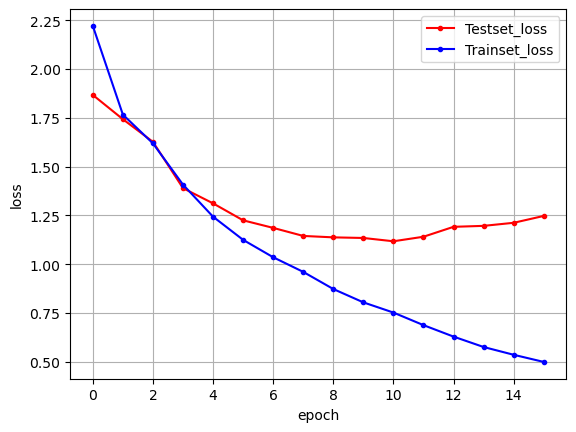

In [8]:
# 학습셋과 테스트셋의 오차를 저장합니다. 
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현해 보겠습니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시하겠습니다. 
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## 2. LSTM과 CNN의 조합을 이용한 영화 리뷰 분류하기

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt

# 데이터를 불러와 학습셋, 테스트셋으로 나눕니다.
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=5000)

# 단어의 수를 맞추어 줍니다. 
X_train = sequence.pad_sequences(X_train, maxlen=500)
X_test = sequence.pad_sequences(X_test, maxlen=500)

# 모델의 구조를 설정합니다.
model = Sequential()
model.add(Embedding(5000, 100))
model.add(Dropout(0.5))
model.add(Conv1D(64, 5, padding='valid', activation='relu',strides=1))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(55))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.summary()

In [22]:
# 데이터 전처리 과정은 로이터 뉴스 데이터와 거의 같음
# 다만 클래스는 긍정 또는 부정 -> 원-핫 인코딩 필요없음
print('훈련용 리뷰 개수 : {}'.format(len(X_train)))
print('테스트용 리뷰 개수 : {}'.format(len(X_test)))
num_classes = len(set(y_train))
print('카테고리 : {}'.format(num_classes))

훈련용 리뷰 개수 : 25000
테스트용 리뷰 개수 : 25000
카테고리 : 2


In [18]:
print(X_train[0])
print(y_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 2, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 2, 19, 178, 32]
1


In [19]:
len_result = [len(s) for s in X_train]
print('리뷰의 최대 길이 : {}'.format(np.max(len_result)))
print('리뷰의 평균 길이 : {}'.format(np.mean(len_result)))

리뷰의 최대 길이 : 2494
리뷰의 평균 길이 : 238.71364


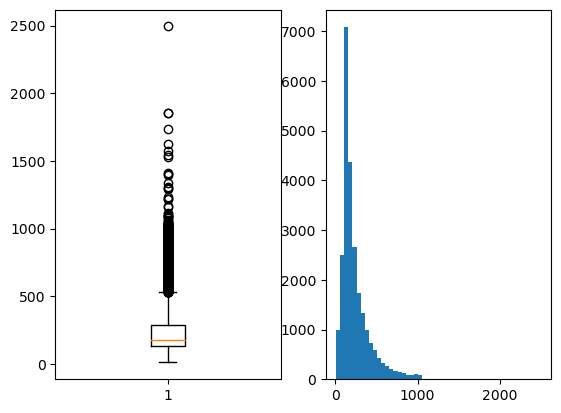

In [20]:
plt.subplot(1,2,1)
plt.boxplot(len_result)
plt.subplot(1,2,2)
plt.hist(len_result, bins=50)
plt.show()

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt

# 데이터를 불러와 학습셋, 테스트셋으로 나눕니다.
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=5000)

# 단어의 수를 맞추어 줍니다. 
X_train = sequence.pad_sequences(X_train, maxlen=500)
X_test = sequence.pad_sequences(X_test, maxlen=500)

# 모델의 구조를 설정합니다.
model = Sequential()
model.add(Embedding(5000, 100))
model.add(Dropout(0.5))
model.add(Conv1D(64, 5, padding='valid', activation='relu',strides=1))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(55))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         500000    
                                                                 
 dropout_1 (Dropout)         (None, None, 100)         0         
                                                                 
 conv1d_1 (Conv1D)           (None, None, 64)          32064     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, None, 64)          0         
 g1D)                                                            
                                                                 
 lstm_2 (LSTM)               (None, 55)                26400     
                                                                 
 dense_2 (Dense)             (None, 1)                 56        
                                                      

- 출력결과에서 Conv1D와 MaxPooling1D가 있음
- 2차원 배열을 가진 이미지와는 다르게 지금의 데이터는 배열 형태로 이루어진 1차원이기 때문에 Conv2D의 개념을 1차원으로 옮긴 것을 사용함
- 컨볼루션 층이 1차원, 이동하는 배열도 1차원

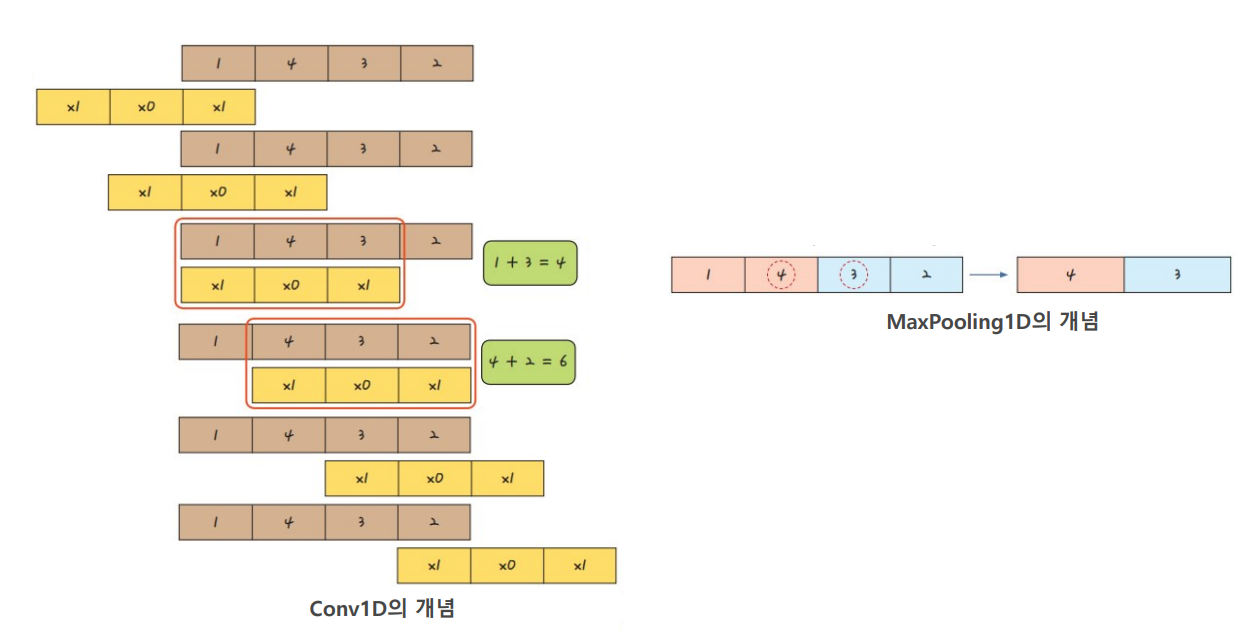

In [25]:
# 모델의 실행 옵션을 정합니다.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 학습의 조기 중단을 설정합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

# 모델을 실행합니다.
history = model.fit(X_train, y_train, batch_size=40, epochs=100, validation_split=0.25, callbacks=[early_stopping_callback])

# 테스트 정확도를 출력합니다.
print("\n Test Accuracy: %.4f" % (model.evaluate(X_test, y_test)[1]))

Epoch 1/100
469/469 [==============================] - 82s 169ms/step - loss: 0.4039 - accuracy: 0.8007 - val_loss: 0.3124 - val_accuracy: 0.8736
Epoch 2/100
469/469 [==============================] - 78s 165ms/step - loss: 0.2387 - accuracy: 0.9076 - val_loss: 0.2770 - val_accuracy: 0.8861
Epoch 3/100
469/469 [==============================] - 81s 173ms/step - loss: 0.1852 - accuracy: 0.9295 - val_loss: 0.2641 - val_accuracy: 0.8941
Epoch 4/100
469/469 [==============================] - 76s 161ms/step - loss: 0.1427 - accuracy: 0.9498 - val_loss: 0.2752 - val_accuracy: 0.8907
Epoch 5/100
469/469 [==============================] - 79s 169ms/step - loss: 0.1135 - accuracy: 0.9610 - val_loss: 0.3127 - val_accuracy: 0.8859
Epoch 6/100
782/782 [==============================] - 26s 33ms/step - loss: 0.3678 - accuracy: 0.8766

 Test Accuracy: 0.8766


In [ ]:
# 학습셋과 테스트셋의 오차를 저장합니다. 
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현해 보겠습니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시하겠습니다. 
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## 어탠션을 사용한 신경망

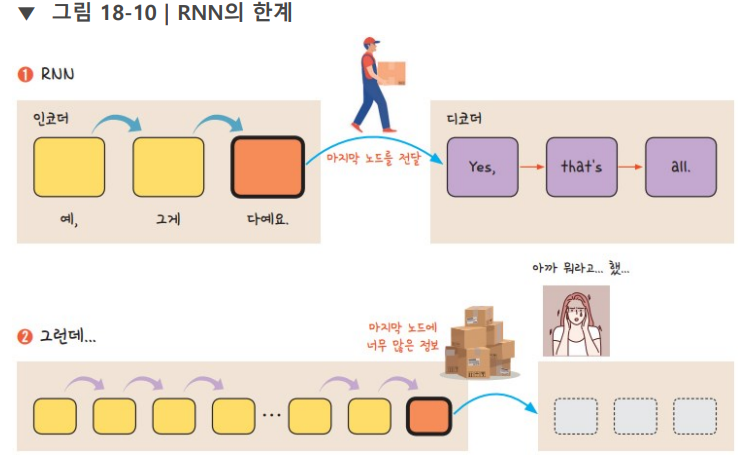
- RNN은 여러 개의 입력값이 있을 때 이를 바로 처리하는 것이 아니라 잠시 가지고 있는 것
- 입력된 값끼리 서로 연관이 있다면, 이를 모두 받아 두어야 적절한 출력 값을 만들 수 있음
- 위 그림은 인코더에 입력된 각 셀 값을 하나씩 뒤로 보내다가, 맨 마지막 셀이 이 값을 디코더에 전달하는 것을 보여줌
- 이 마지막 셀에 담긴 값에 전체 문장의 뜻이 함축되어 있으므로 이를 **문맥 벡터**라고 함
- 입력 값의 길이가 너무 길면 입력받은 셀의 결과들이 너무 많아짐
    - 선두에서 전달받은 결괏값이 중간에 희미해지고, 문맥 벡터가 모든 값을 제대로 디코더에 전달하기 힘들어지는 문제가 생김

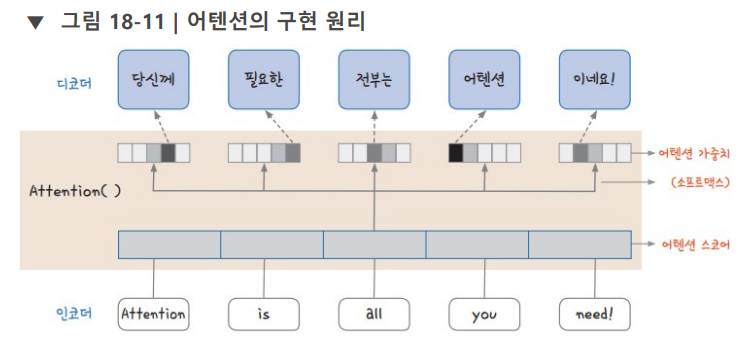

- 인코더와 디코더 사이에 층이 하나 생김
- 새로 생긴 층에는 각 셀로부터 계산될 스코어들이 모임
- 이 스코어를 이용해 소프트맥스 함수를 사용해서 어텐션 가중치를 만듬
- 이 가중치를 이용해 입력 값중 어떤 셀을 볼지 결정
- 이러한 방식으로 매 출력마다 모든 입력 값을 두루 활용하는 것이 어텐션
- 마지막 셀이 모든 입력이 집중되던 RNN의 단점을 극복한 알고리즘

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from attention import Attention

import numpy as np
import matplotlib.pyplot as plt

# 데이터를 불러와 학습셋, 테스트셋으로 나눕니다.
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=5000)

# 단어의 수를 맞추어 줍니다. 
X_train = sequence.pad_sequences(X_train, maxlen=500)
X_test = sequence.pad_sequences(X_test, maxlen=500)

# 모델의 구조를 설정합니다.
model = Sequential()
model.add(Embedding(5000, 500))
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=True))
model.add(Attention())
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

# 모델의 실행 옵션을 정합니다.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 학습의 조기 중단을 설정합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

# 모델을 실행합니다.
history = model.fit(X_train, y_train, batch_size=40, epochs=100,  validation_data=(X_test, y_test), callbacks=[early_stopping_callback])

# 테스트 정확도를 출력합니다.
print("\n Test Accuracy: %.4f" % (model.evaluate(X_test, y_test)[1]))

Epoch 1/100
625/625 [==============================] - 634s 1s/step - loss: 0.3703 - accuracy: 0.8334 - val_loss: 0.2758 - val_accuracy: 0.8867
Epoch 2/100
625/625 [==============================] - 629s 1s/step - loss: 0.2258 - accuracy: 0.9109 - val_loss: 0.2864 - val_accuracy: 0.8823
Epoch 3/100
625/625 [==============================] - 597s 955ms/step - loss: 0.1674 - accuracy: 0.9348 - val_loss: 0.2815 - val_accuracy: 0.8895
Epoch 4/100
782/782 [==============================] - 107s 137ms/step - loss: 0.3478 - accuracy: 0.8853

 Test Accuracy: 0.8853


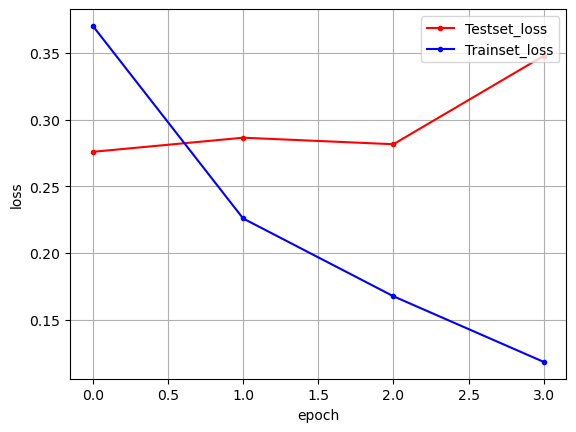

In [27]:
# 학습셋과 테스트셋의 오차를 저장합니다. 
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현해 보겠습니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시하겠습니다. 
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()